In [28]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import pickle

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
train_df = pd.read_csv('/content/train.csv')
print("Train_shape:",train_df.shape)
test_df = pd.read_csv('/content/test.csv')

Train_shape: (1306122, 3)


In [30]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [33]:
labels = Counter(train_df['target']).keys()
amounts = Counter(train_df['target']).values()
labels, amounts

(dict_keys([0, 1]), dict_values([1225312, 80810]))

In [23]:
train_df.head()


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


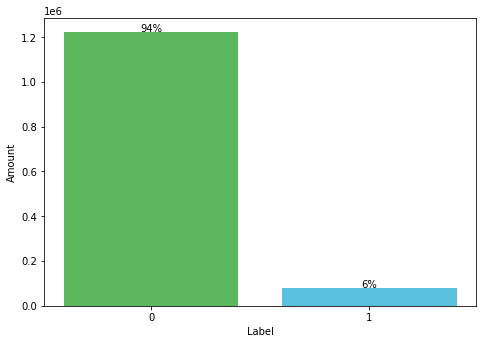

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
_labels = ['0', '1']
colors_list = ['#5cb85c','#5bc0de']
ax.bar(_labels, amounts, color=colors_list)

plt.xlabel('Label')
plt.ylabel('Amount')

for i in ax.patches:
    height = i.get_height()
    width = i.get_width()
    x, y = i.get_xy()
    ax.annotate(f'{height/1306122:.0%}', (x + width/2, height), ha='center')

plt.show()

In [36]:
sincere_percent= (len(train_df.question_text[train_df['target'] == 0]) /  len(train_df['question_text']) * 100)
insincere_percent= (len(train_df.question_text[train_df['target'] == 1]) / len(train_df['question_text']) * 100)
sincere_percent, insincere_percent

(93.81298224821265, 6.187017751787352)

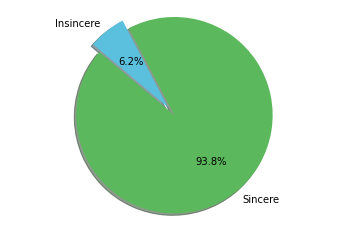

In [37]:
__labels = 'Sincere', 'Insincere'
sizes = [sincere_percent, insincere_percent]
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=__labels, colors=colors_list,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

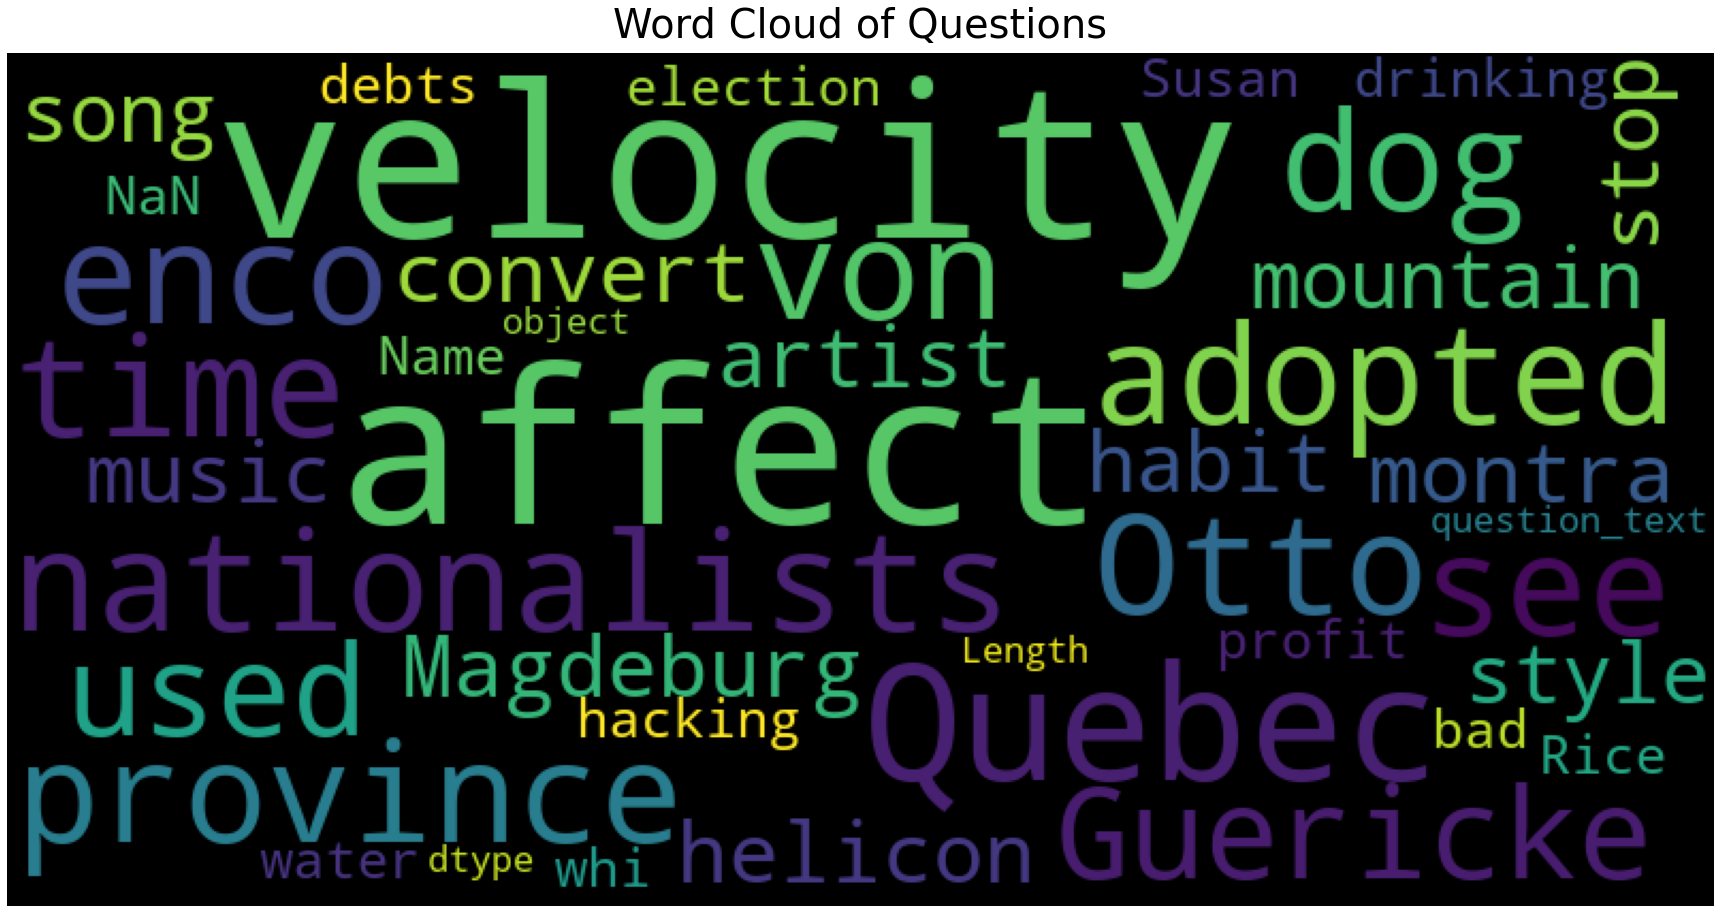

In [6]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

In [42]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:
def plot_top_stopwords_barchart(texts):
    ques = texts.str.split()
    ques = ques.values.tolist()
    corpus = [word for q in ques for word in q]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop_words:
            dic[word]+=1
            
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y = zip(*top)
    plt.bar(x,y)
    plt.title('Top 10 stopword')

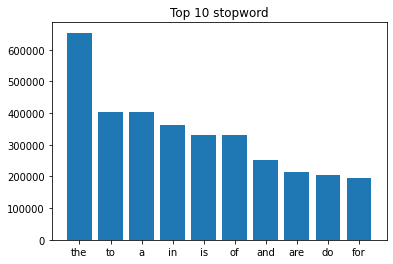

In [44]:
plot_top_stopwords_barchart(train_df['question_text'])


In [49]:
# Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

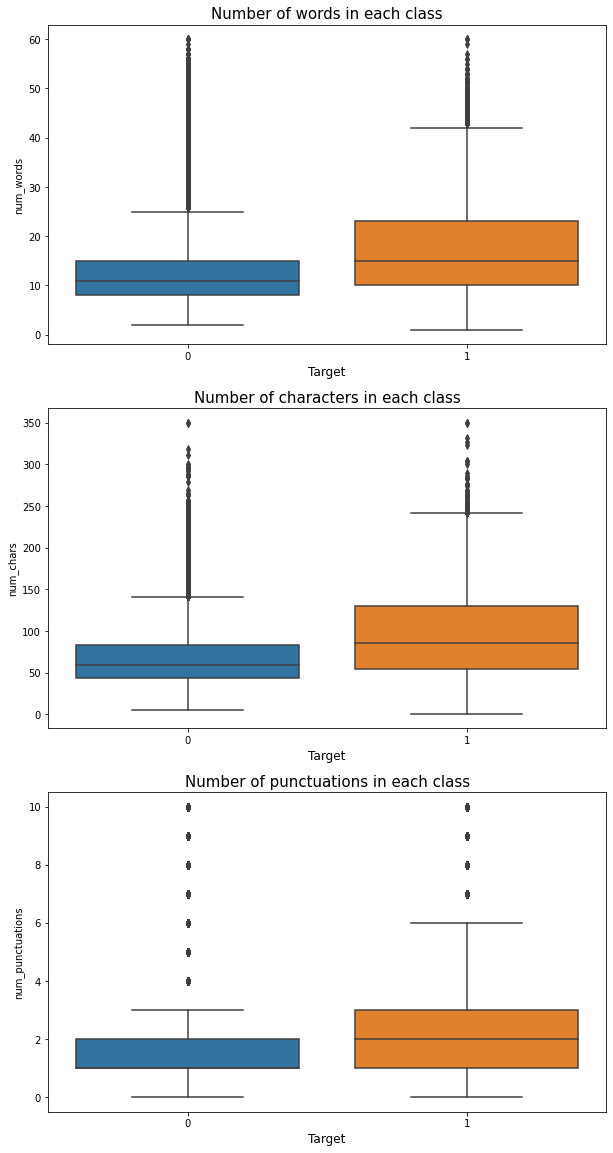

In [50]:
# Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()